## Importing libraries

In [1]:
import os
import pandas as pd
import zipfile
import numpy as np
import squarify
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns  

Matplotlib is building the font cache using fc-list. This may take a moment.


# EDA

The purpose of our EDA is to find insights that will help us later to how clean our data and ultimately create our models.


**Note**: 

1.This is the EDA for baseline MRI data, which is our data of focus in the first experiment. In the first experiment, we plan to do a cross-sectional prediction, namely predicting whether the patient has Alzheimer or not. We will take care of the temporal effect in the second experiment.

2.This is the EDA for meta data/data dictionary only. The EDA for images themselves is in {TODO: fill in the blank} file


In [2]:
os.getcwd()

'/accounts/grad/khern045/NeuroimagingCapstone/scripts'

Creating data paths

In [14]:
base_path = os.path.join('/accounts', 'grad', 'khern045', 'NeuroimagingCapstone')
bl_3t_md_file = 'ADNI1_Baseline_3T.csv'  # data dictionary
bl_path = os.path.join(base_path, 'data', 'adni1-data', bl_3t_md_file)

dir_path = os.path.realpath(bl_3t_md_file)
dir_path

'/accounts/grad/khern045/NeuroimagingCapstone/scripts/ADNI1_Baseline_3T.csv'

Read in data

In [10]:
df = pd.read_csv(baseline_path, parse_dates=['Acq Date'])
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/accounts/grad/khern045/NeuroimagingCapstone/data/adni1-data/ADNI1_Baseline_3T.csv'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Image Data ID  199 non-null    object        
 1   Subject        199 non-null    object        
 2   Group          199 non-null    object        
 3   Sex            199 non-null    object        
 4   Age            199 non-null    int64         
 5   Visit          199 non-null    object        
 6   Modality       199 non-null    object        
 7   Description    199 non-null    object        
 8   Type           199 non-null    object        
 9   Acq Date       199 non-null    datetime64[ns]
 10  Format         199 non-null    object        
 11  Downloaded     199 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 18.8+ KB


Here we can see that there are no null values. Most are of type object. We can also see that there are unnecessary variables like Format, Downloaded, Modality, Visit. We can plan to remove those later

#### Drop unused columns
#### Split up date into year, month, day columns

In [ ]:
df = df.drop(['Visit', 'Modality', 'Type', 'Format', 'Downloaded'], axis=1, errors = 'ignore')

df['Acq_year'] = pd.DatetimeIndex(df['Acq Date']).year
df['Acq_month'] = pd.DatetimeIndex(df['Acq Date']).month
df['Acq_day'] = pd.DatetimeIndex(df['Acq Date']).day
df = df.drop(['Acq Date'], axis=1, errors = 'ignore')
df.head()

,Image Data ID,Subject,Group,Sex,Age,Description,Acq_year,Acq_month,Acq_day
0,I122678,031_S_0568,MCI,F,80,MPR; GradWarp; N3; Scaled,2006,6,9
1,I118854,023_S_0061,CN,F,77,MPR; GradWarp; B1 Correction; N3; Scaled_2,2005,12,20
2,I119018,023_S_0331,MCI,F,65,MPR; GradWarp; B1 Correction; N3; Scaled_2,2006,4,12
3,I118920,023_S_1190,CN,F,77,MPR; GradWarp; B1 Correction; N3; Scaled_2,2007,1,17
4,I118862,023_S_0078,MCI,F,76,MPR; GradWarp; B1 Correction; N3; Scaled_2,2006,1,12


Change the names of some columsn to remove spaces and make for easier coding

In [ ]:
df = df.rename({'Image Data ID': 'Img_ID', 'Description':"Desc"}, axis=1) 
df.head()

,Img_ID,Subject,Group,Sex,Age,Desc,Acq_year,Acq_month,Acq_day
0,I122678,031_S_0568,MCI,F,80,MPR; GradWarp; N3; Scaled,2006,6,9
1,I118854,023_S_0061,CN,F,77,MPR; GradWarp; B1 Correction; N3; Scaled_2,2005,12,20
2,I119018,023_S_0331,MCI,F,65,MPR; GradWarp; B1 Correction; N3; Scaled_2,2006,4,12
3,I118920,023_S_1190,CN,F,77,MPR; GradWarp; B1 Correction; N3; Scaled_2,2007,1,17
4,I118862,023_S_0078,MCI,F,76,MPR; GradWarp; B1 Correction; N3; Scaled_2,2006,1,12


#### Split Desc column into binary

In [ ]:
df.Desc.unique()

array(['MPR; GradWarp; N3; Scaled',
       'MPR; GradWarp; B1 Correction; N3; Scaled_2',
       'MPR; GradWarp; B1 Correction; N3; Scaled', 'MPR; ; N3; Scaled_2',
       'MPR; ; N3; Scaled',
       'MPR-R; GradWarp; B1 Correction; N3; Scaled_2',
       'MPR-R; GradWarp; B1 Correction; N3; Scaled',
       'MPR-R; ; N3; Scaled_2', 'MPR-R; ; N3; Scaled'], dtype=object)

In [ ]:
# https://stackoverflow.com/a/29036042/16800940
desc_df = pd.get_dummies(df.Desc.replace({'(Scaled_2)':'Scaled'}, regex=True).str.split("; ").apply(pd.Series).stack()).sum(level=0)
desc_df.rename({'B1 Correction':'B1'})

dfc = pd.concat([df, desc_df.iloc[:, 1:]], axis=1).drop('Desc', axis=1)
dfc.head()

<ipython-input-9-5fe0f95744f9>:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  desc_df = pd.get_dummies(df.Desc.replace({'(Scaled_2)':'Scaled'}, regex=True).str.split("; ").apply(pd.Series).stack()).sum(level=0)


,Img_ID,Subject,Group,Sex,Age,Acq_year,Acq_month,Acq_day,B1 Correction,GradWarp,MPR,MPR-R,N3,Scaled
0,I122678,031_S_0568,MCI,F,80,2006,6,9,0,1,1,0,1,1
1,I118854,023_S_0061,CN,F,77,2005,12,20,1,1,1,0,1,1
2,I119018,023_S_0331,MCI,F,65,2006,4,12,1,1,1,0,1,1
3,I118920,023_S_1190,CN,F,77,2007,1,17,1,1,1,0,1,1
4,I118862,023_S_0078,MCI,F,76,2006,1,12,1,1,1,0,1,1


MRI images from the ADNI dataset, we think, come partially preprocessed. 

ADNI Pipeline uses is a preprocessing pipeline used to perform a series of steps to convert the raw image into a preprocessed image. 

These steps can include N3/N4 bias correction, skull stripping, registration, intensity normalization, scaling and spatial normalization.

Preprocessing Definitions:
  > **N3**: Correct for intensity non-uniformity in the image, which can be caused by a variety of factors including differences in coil sensitivity, magnetic field inhomogeneities, and tissue properties.

  > **N4**: Corrects for intensity non-uniformity in the MRI data caused by variations in the magnetic field and other factors

  > **Gradwarp**: Corrects for intensity variations in the magnetic field of the scnaner, which can cause distortions in the image. These distortions can cause errors in subsequent image processing steps

  > **Distortion correction**: Used to correct for spatial distortions in the image that are caused by factors such as gradient nonlinearities, susceptibility artifacts, and motion.

  > **B1 Correction**: is a type of correction for radiofrequency (RF) inhomogeneity in MRI images. RF inhomogeneity occurs when the RF field is not perfectly uniform across the image.

  > **Skull Stripping**: Removes non-brain tissue from the MRI images

  > **Registration**: Aligns the MRI images to a standard space, such as the MNI (Montreal Neurological Institute) template

  > **Spatial Normalizaiton**: Warps the images to fit the template space, correcting for differences in brain size and shape between individuals
  
  > **Intensity Normalization**: Rescales the intensity values of the images to a common range.

  > **Scaled**: Not too sure what this is. On the documentation they have parameters scaled(1.00002, 1, 1.0003) or something similar.

  > **Motion correction**: Motion correction is typically performed to correct for subject motion during the acquisition of the images. These artifacts can cause blurring or ghosting in the image, which can affect subsequent image processing steps.

  > **Smoothing**: Spatial smoothing is performed to improve the signal-to-noise ratio of the images and to reduce noise and other unwanted variability.

We think that they become preprocessed, because the images are not intensity normalized or skull stripped. 

We know for sure that they are N3 bias corrected, Gradwarped, scaled. I want to say that they're also registered. 

**MPR and MPR_R**:
In ADNI preprocessing, MPR and MPR-R refer to two different acquisitions of the same imaging modality, specifically the magnetization-prepared rapid gradient echo (MPRAGE) sequence. MPR refers to the first acquisition of the MPRAGE sequence, while MPR-R refers to a repeat acquisition that is obtained immediately after the first acquisition.

The purpose of acquiring two MPRAGE scans in quick succession is to improve the quality of the image by reducing the effects of noise, motion artifacts, and other sources of variability. The two scans are then averaged or combined in some way to produce a single high-quality image.


#### Check NA

In [ ]:
def count_nulls(df):
    null_counter = df.isnull().sum(axis=0)
    null_counter = null_counter[null_counter > 0]
    null_percent = df.isnull().sum(axis=0) / df.shape[0] * 100
    null_percent = null_percent[null_percent > 0]
    null_df = pd.concat([null_counter,null_percent],axis=1)
    null_df.columns = ['count','percent']
    display(null_df)
    
count_nulls(dfc)

,count,percent


#### Subject

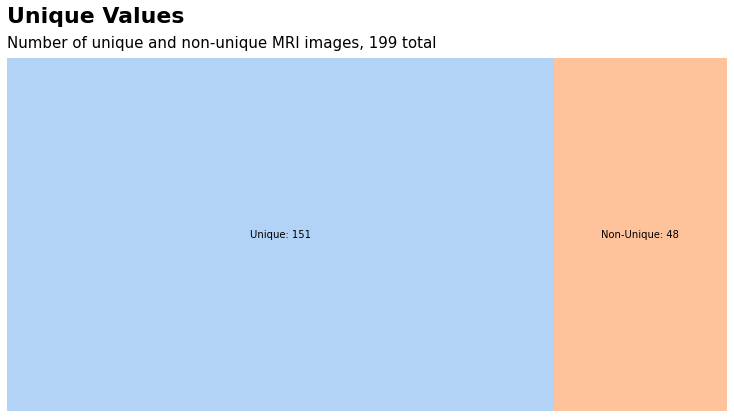

In [ ]:
unique_vals = len(dfc.Subject.unique())
n = dfc.shape[0]


############# PLOT
color = sns.color_palette("pastel")
fig, ax = plt.subplots(figsize=(10, 7))
squarify.plot(sizes=[unique_vals, n-unique_vals], label=[f'Unique: {unique_vals}', f'Non-Unique: {n-unique_vals}'], alpha=.8, color=color)
ax.axis('off')

# remove padding left and right, add some to top and bot
fig.subplots_adjust(left=0, right=1, top=0.8, bottom=0.1)

# Add title
fig.text(
    0, 0.87, "Unique Values", 
    fontsize=22, fontweight="bold"
)

# Add subtitle
fig.text(
    0, 0.82, "Number of unique and non-unique MRI images, 199 total", 
    fontsize=15
)
plt.show()


31.78% of the data is not unique. This means that some of our data will be of the exact same person. A person could have 5 MRI scans of them taken, or 2. Having the same photo taken of a person but 5 days apart, could be useless and make cause bias in the model. We might have to remove them later or find a new dataset

<ipython-input-14-033b7c54568a>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([i * 20 for i in range(0, 6)], size=16, fontweight=100)


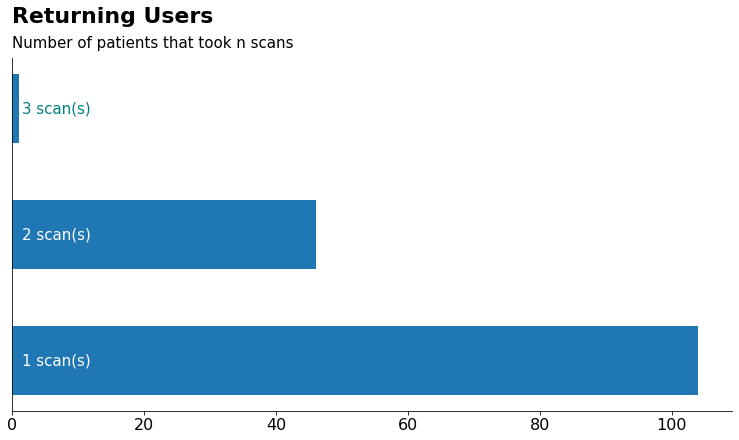

In [ ]:
duplicates = dfc.groupby(['Subject']).size().value_counts()
names = list(map(str, duplicates.index))
counts = duplicates.values


############# PLOT
fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(names, counts, height=0.55)

# remove padding left and right, add some to top and bot
fig.subplots_adjust(left=0, right=1, top=0.8, bottom=0.1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_yaxis().set_visible(False)

# xlabels
ax.xaxis.set_ticklabels([i * 20 for i in range(0, 6)], size=16, fontweight=100)

# y labels
for name, count in zip(names, counts):
  if count < 8:
    x = count
    color = 'teal'
  else:
     x = 1
     color = 'white'
  ax.text(
      x + 0.5, int(name) - 1, name + ' scan(s)', fontsize=15, color=color, va="center",
  )

# Add title
fig.text(
    0, 0.87, "Returning Users", 
    fontsize=22, fontweight="bold"
)

# Add subtitle
fig.text(
    0, 0.82, "Number of patients that took n scans", 
    fontsize=15
)

plt.show()

<ipython-input-15-aacfdb41b0ae>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([i * 10 for i in range(0, 5)], size=16, fontweight=100)


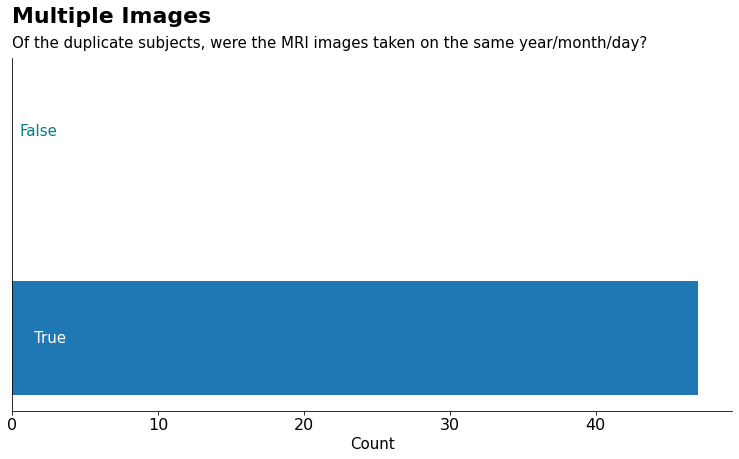

In [ ]:
# dfc.groupby(['Subject']).size().apply(lambda x: (x > 1)).index
dup_rows = dfc[dfc['Subject'].duplicated(keep=False)].loc[:,['Img_ID','Subject','Acq_year','Acq_month','Acq_day','MPR','MPR-R']]
# duplicate rows group by yr and day
dup_row_gb_yrd = dup_rows.groupby(['Subject', 'Acq_year','Acq_day']).size()
count_dups = np.unique((dup_row_gb_yrd.sort_values(ascending=False) > 1).values, return_counts=True)

names = np.append(count_dups[0],'False')
counts = np.append(count_dups[1], 0)


############# PLOT
fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(names, counts, height=0.55)

# remove padding left and right, add some to top and bot
fig.subplots_adjust(left=0, right=1, top=0.8, bottom=0.1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_yaxis().set_visible(False)

# xlabels
ax.xaxis.set_ticklabels([i * 10 for i in range(0, 5)], size=16, fontweight=100)

# y labels
for name, count in zip(names, counts):
  if count < 8:
    x = count
    color = 'teal'
  else:
     x = 1
     color = 'white'
  ax.text(
      x + 0.5, np.where(names == name), name, fontsize=15, color=color, va="center",
  )

ax.set_xlabel("Count", fontsize=15)

# Add title
fig.text(
    0, 0.87, "Multiple Images", 
    fontsize=22, fontweight="bold"
)

# Add subtitle
fig.text(
    0, 0.82, "Of the duplicate subjects, were the MRI images taken on the same year/month/day?", 
    fontsize=15
)

plt.show()
#######################

Every single duplicate subject had two (three for one individual) images taken on the same day. This could be due to MPR/MPR-R acquisitions where researchers take multiple MRI scans in order to improve the quality of the image. They take the average of the two images in hopes to reduce the noise and motion effects. 

This is something we will have to deal with later. We can remove the datapoints or we can do the MPR/MPR-R preprocessing talked about in the previous paragraph.

#### Age

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


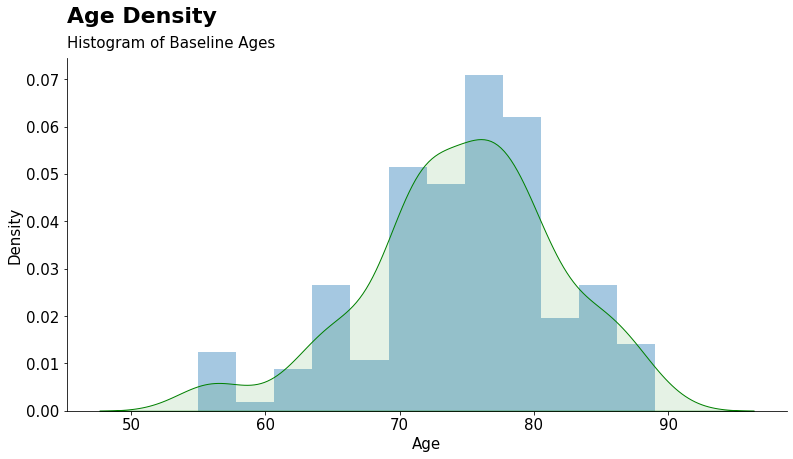

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


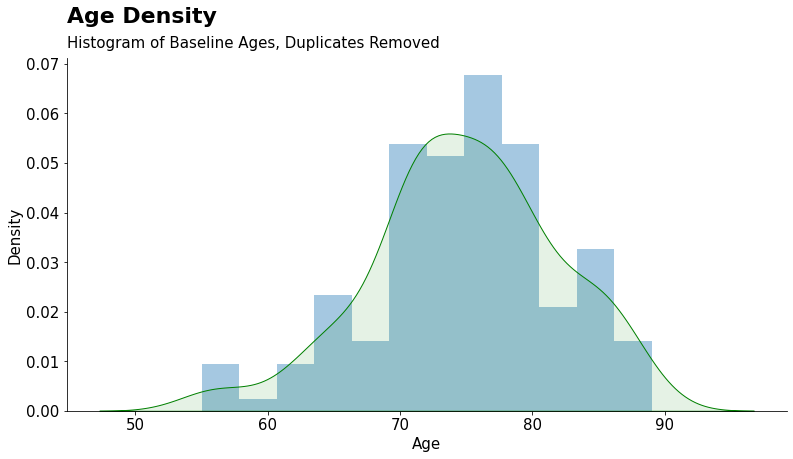

In [ ]:
# df dupes removed
dfdr = dfc.drop_duplicates('Subject')

def plot_hist(ser, bins, sub_title='Histogram of Baseline Ages'):
  ############# PLOT
  fig, ax = plt.subplots(figsize=(10, 7))
  sns.distplot(a=ser, hist=True, kde=True, rug=False, bins=bins, 
               kde_kws={"color": "g", "alpha": 0.1, "linewidth": 1, "shade": True})
  # sns.histplot(data=dfc['Age'], kde=True, stat='density', ax=ax, bins=20)


  # remove padding left and right, add some to top and bot
  fig.subplots_adjust(left=0, right=1, top=0.8, bottom=0.1)

  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)

  # y and x ticks
  ax.tick_params(axis='both', which='major', labelsize=15)

  # y labels
  ax.set_ylabel("Density", fontsize=15)
  ax.set_xlabel("Age", fontsize=15)

  # Add title
  fig.text(
      0, 0.87, "Age Density", 
      fontsize=22, fontweight="bold"
  )

  # Add subtitle
  fig.text(
      0, 0.82, sub_title, 
      fontsize=15
  )

  plt.show()
  #######################

plot_hist(dfc['Age'], 12)
plot_hist(dfdr['Age'], 12, "Histogram of Baseline Ages, Duplicates Removed")

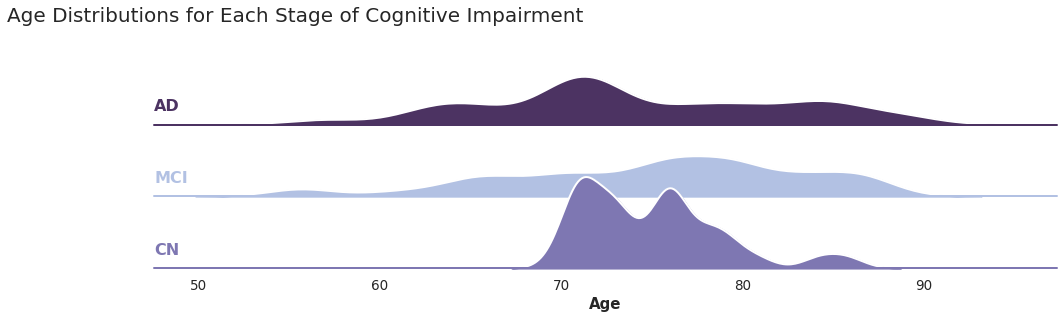

In [ ]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(n_colors=3, start=0.4, rot=-.25, light=.75, dark=0.25)
g = sns.FacetGrid(dfdr, row="Group", hue="Group", aspect=9, height=1.5, palette=pal, row_order=['AD', 'MCI', 'CN'])

# Draw the densities in a few steps
g.map(sns.kdeplot, "Age",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Age", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", fontsize=16, transform=ax.transAxes)
    plt.xlabel('Age', fontweight='bold', fontsize=15)
    plt.setp(ax.get_xticklabels(), fontsize=13.5)

g.map(label, "Age")

# subtitle
g.fig.suptitle('Age Distributions for Each Stage of Cognitive Impairment',
               ha='right',
               fontsize=20,
               fontweight=20)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

Age group is roughly normal with and without the duplicates.

### Group

<AxesSubplot:xlabel='Group'>

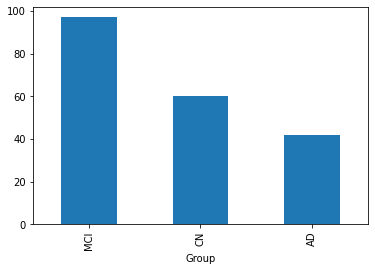

In [ ]:
dfc.value_counts('Group').plot.bar()

From the data, we can see that most of subjects have Mild Cognitive Impairment.

#### Sex

11

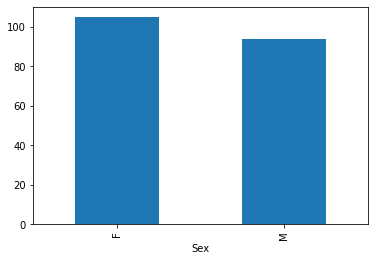

In [ ]:
dfc.value_counts('Sex').plot.bar()
len(dfc[dfc['Sex'] == 'F']) - len(dfc[dfc['Sex'] == 'M'])

There are more women subjects in the data, thouogh the difference is not very big. 

Group/Sex

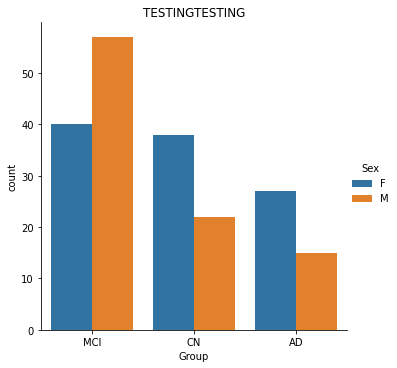

In [ ]:
dfc.groupby(['Sex', 'Group']).size().unstack(fill_value=0)
sns.catplot(x = "Group",       # x variable name
            hue = "Sex",  # group variable name
            data = df,     # dataframe to plot
            kind = "count").set(title="TESTINGTESTING")

plt.show()

Interesting, we find that actually men subjects have more Mild Cognitive Impairment.

#### Year

<AxesSubplot:xlabel='Acq_year'>

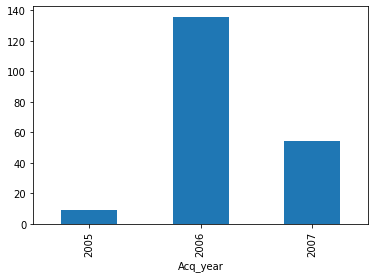

In [ ]:
dfc.value_counts('Acq_year').sort_index().plot.bar()

Most frequent acquisition date is 2006.

### Correlation Matrix

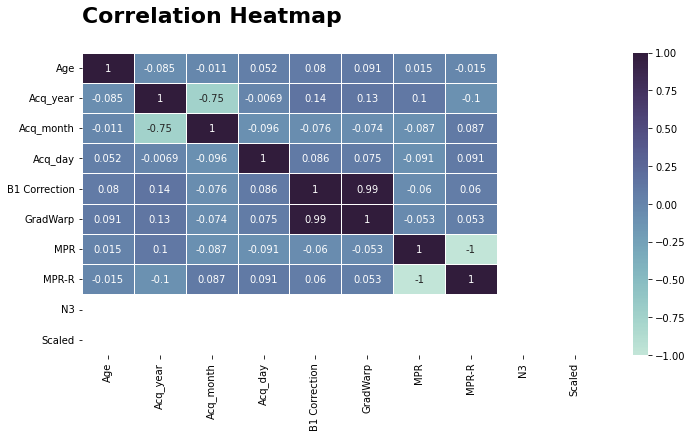

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
fig.subplots_adjust(left=0, right=1, top=0.8, bottom=0.1)
pal = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

# all the values of N3 and Scaled are 1, thus dropping them
sns.heatmap(dfdr.corr(),annot=True,linewidths=0.95, cmap=pal, annot_kws={"size": 10}, ax=ax)
  # Add title
fig.text(
    0, 0.87, "Correlation Heatmap", 
    fontsize=22, fontweight="bold"
)
plt.show()

In [ ]:
print(dfc['N3'].unique())
print(dfc['Scaled'].unique())

array([0, 1], dtype=uint8)

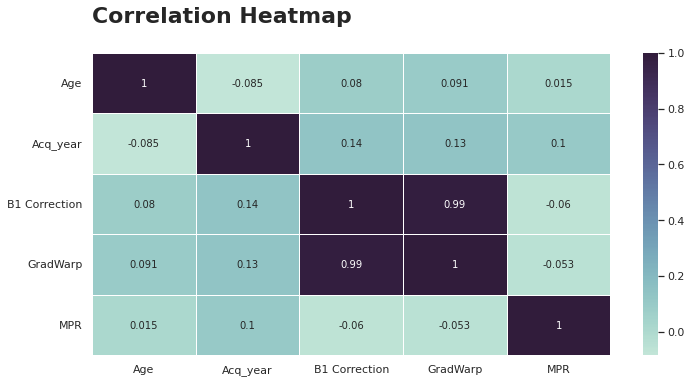

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
fig.subplots_adjust(left=0, right=1, top=0.8, bottom=0.1)
pal = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

# all the values of N3 and Scaled are 1, thus dropping them
sns.heatmap(dfdr.drop(['Acq_month', 'Acq_day', 'N3', 'Scaled','MPR-R'], axis = 1).corr(),\
            annot=True,linewidths=0.95, cmap=pal, annot_kws={"size": 10}, ax=ax)
  # Add title
fig.text(
    0, 0.87, "Correlation Heatmap", 
    fontsize=22, fontweight="bold"
)
plt.show()

Everything has almost 0 correlation. B1 Correction and GradWarp seem to be connected because they both correct image intensities caused by the MRI machine. We get NA values for N3 and Scaled because the values don't vary. If $x_i - \bar{x} = 0 \ ∀ \ x ∈ X$ then $𝜌 = \text{undefined}$. In this case, all x values are 1.

$$
𝜌_{xy} = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum(x_i - \bar{x})^2 \sum(y_i - \bar{y})^2}}
$$


In [ ]:
# clean with duplicates
dfc.to_parquet(os.path.join(base_path, baseline_path, 'ADNI1_Baseline_3T_2_25_2023_clean_wd.parquet'))
# clean with out duplicates
dfdr.to_parquet(os.path.join(base_path, baseline_path, 'ADNI1_Baseline_3T_2_25_2023_clean_wod.parquet'))